# CatBoost Algorithm

- CatBoost is a state-of-the-art open-source gradient boosting on decision tree library
- It is developed by Yandex reseacrhers and engineers and is used for search recommendation systems personal assistand  
self-driving cars,weather predicitin and many other tasks at Yandex and in other companies,
- It is in Python and it is designed to be integrated in Data Science Pipline,
- It provides state-of-the-art results and it is powerful in handlinig categorical features,
- Do we need to encode categorical features before training the model? No, CatBoost does not require it.
- It is efficient it provides a fast and scalable multi-threaded implementation of algorithm,
- It provide powerful visulalization tools to understand the model

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [53]:
# data import titanic
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Data Pre-processing

In [54]:
df.isnull().sum().sort_values(ascending=False)

deck           688
age            177
embarked         2
embark_town      2
survived         0
pclass           0
sex              0
sibsp            0
parch            0
fare             0
class            0
who              0
adult_male       0
alive            0
alone            0
dtype: int64

In [55]:
# impute missing values using knn imputer in age

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df['age'] = imputer.fit_transform(df[['age']])

# impute embarked missing values using pandas
df['embarked'].fillna(df['embarked'].mode()[0])
df['embark_town'] = df['embark_town'].fillna(df['embark_town'].mode()[0])
# drop deck column
df.drop('deck', axis=1, inplace=True)

# df missing values
df.isnull().sum().sort_values(ascending=False)


embarked       2
survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
dtype: int64

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  embark_town  891 non-null    object  
 12  alive        891 non-null    object  
 13  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(5)
memory usage: 79.4+ KB


In [59]:
df = df.drop(['alive'], axis=1)
# convert each categorical/object column to category
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
# add this as a new column in the dataframe
df[categorical_cols] = df[categorical_cols].astype('category')


In [60]:
df.dtypes

survived          int64
pclass            int64
sex            category
age             float64
sibsp             int64
parch             int64
fare            float64
embarked       category
class          category
who            category
adult_male         bool
embark_town    category
alone              bool
dtype: object

In [62]:
# split data into x and y
X = df.drop(['survived',], axis=1)
y = df['survived']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [63]:
# fill NaN in categorical columns
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str).fillna("Missing")
    X_test[col] = X_test[col].astype(str).fillna("Missing")


Accuracy Score: 0.8161434977578476
Confusion Matrix:
[[118  16]
 [ 25  64]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       134
           1       0.80      0.72      0.76        89

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.80       223
weighted avg       0.82      0.82      0.81       223

CPU times: total: 906 ms
Wall time: 958 ms


Text(0.5, 1.0, 'Confusion Matrix')

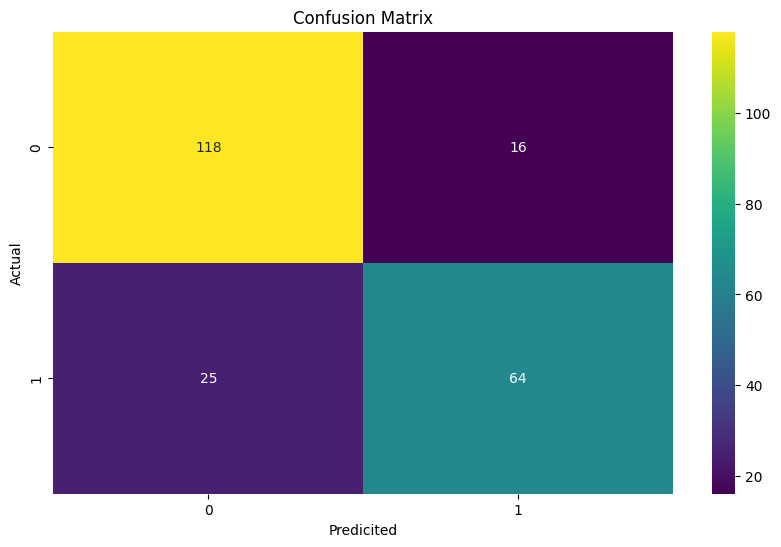

In [64]:
%%time
# run the catboost classifier
model = CatBoostClassifier(iterations=10, learning_rate=0.1, depth=3,loss_function='Logloss',
                           eval_metric="Accuracy",
                           random_seed=42,
                           verbose=False)
# train the model
model.fit(X_train, y_train, cat_features=categorical_cols.tolist())

# predictions
y_pred = model.predict(X_test)

# evaluate the model
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# plot confusin matrix
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicited')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


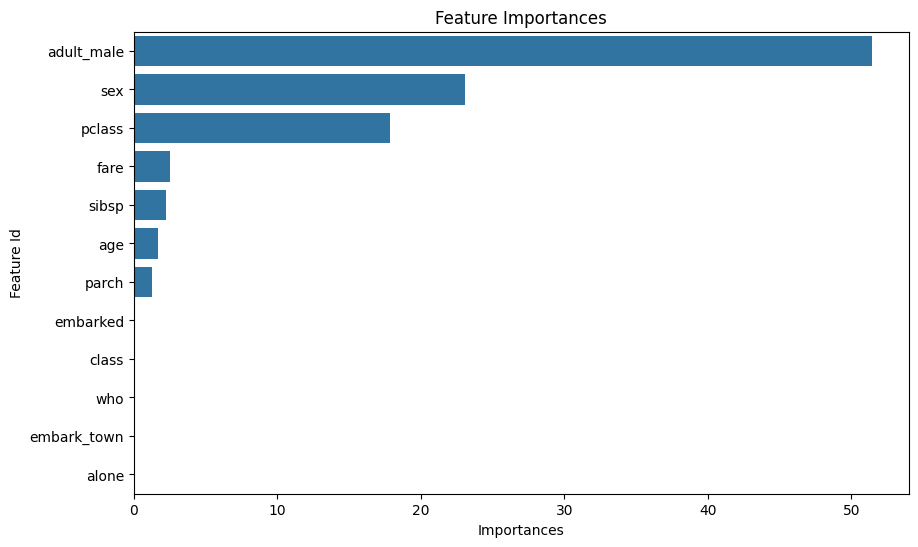

In [65]:
# Feartue importance
feature_importances = model.get_feature_importance(prettified=True)
plt.figure(figsize=(10,6))
sns.barplot(x='Importances', y='Feature Id', data=feature_importances)
plt.title('Feature Importances')
plt.show()
